<a href="https://colab.research.google.com/github/yuxizhe/HTML-UI-datasets-generate/blob/master/html%E5%85%83%E7%B4%A0%E5%88%86%E7%B1%BB_%E8%BF%81%E7%A7%BB%E5%AD%A6%E4%B9%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tf-nightly
import tensorflow as tf

In [30]:
# TensorFlow and tf.keras

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

2.3.0-dev20200512
2.2.4-tf


In [3]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly
import tensorflow_hub as hub

     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 3.3MB 2.9MB/s 


In [0]:
# create a data generator
datagen = ImageDataGenerator(rescale=(1/255))

图片下载

In [0]:
!cp /content/drive/My\ Drive/Fast.io/ygd.imfast.io/components_pad.zip /content/
!rm -rf components
!unzip components_pad.zip > /dev/null
!rm components_pad.zip


In [0]:
!cp /content/drive/My\ Drive/Fast.io/ygd.imfast.io/valid_pad.zip /content/
!rm -rf valid
!unzip valid_pad.zip > /dev/null
!rm valid_pad.zip

In [7]:
import pathlib
import re

# 文件目录处理
data_dir = pathlib.Path('/content/components_pad_200')
# 获取名称
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if re.search('\.', item.name) == None])
CLASS_NAMES

array(['input', 'select', 'button'], dtype='<U6')

In [0]:
!rm -rf valid_pad_200/
!rm -rf components_pad_200/
resize('/content/components')
resize('/content/valid')

In [65]:
# load and iterate training dataset
# directory: 目标目录的路径。每个类应该包含一个子目录。任何在子目录树下的 PNG, JPG, BMP, PPM 或 TIF 图像，都将被包含在生成器中。更多细节，详见 此脚本。
# target_size: 整数元组 (height, width)，默认：(256, 256)。所有的图像将被调整到的尺寸。
# color_mode: "grayscale", "rbg" 之一。默认："rgb"。图像是否被转换成 1 或 3 个颜色通道。
# classes: 可选的类的子目录列表（例如 ['dogs', 'cats']）。默认：None。如果未提供，类的列表将自动从 directory 下的 子目录名称/结构 中推断出来，其中每个子目录都将被作为不同的类（类名将按字典序映射到标签的索引）。包含从类名到类索引的映射的字典可以通过 class_indices 属性获得。
# class_mode: "categorical", "binary", "sparse", "input" 或 None 之一。默认："categorical"。决定返回的标签数组的类型：
# "categorical" 将是 2D one-hot 编码标签，
# "binary" 将是 1D 二进制标签，"sparse" 将是 1D 整数标签，
train_data = datagen.flow_from_directory('/content/components_pad_200',
                                         target_size=(224,224),
                                        #  color_mode="grayscale",
                                        #  class_mode='binary',
                                        #  batch_size=64,
                                         classes=list(CLASS_NAMES))

Found 69 images belonging to 3 classes.


In [66]:
valid_data = datagen.flow_from_directory('/content/valid_pad_200',
                                         target_size=(224,224),
                                        #  color_mode="grayscale",
                                        #  class_mode='binary',
                                        #  batch_size=64,
                                         classes=list(CLASS_NAMES))

Found 6 images belonging to 3 classes.


In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(5):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n].squeeze())
      # plt.title(CLASS_NAMES[int(label_batch[n])])
      plt.axis('off')

(32, 3)

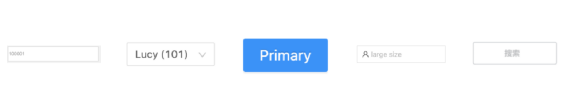

In [70]:
image_batch, label_batch = next(train_data)
show_batch(image_batch, label_batch)
label_batch.shape

In [0]:
# confirm the iterator works
#batchX, batchy = train_data.next()
#x,y = valid_data.next()

In [0]:
# 方法一：全连接的训练
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(200, 200)),
#     keras.layers.Dense(1000, activation='relu'),
#     keras.layers.Dense(100, activation='relu'),
#     keras.layers.Dense(6)
# ])

# 方法二：自建CNN训练
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(500, activation='relu'))
# model.add(layers.Dense(3, activation='softmax'))
# model.summary()

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# fit model
# model.fit_generator(train_data, epochs=10, steps_per_epoch=20, validation_data=valid_data, validation_steps=8)


In [0]:
# 方法三：迁移学习

feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

IMAGE_SHAPE = (224, 224)

feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224, 224, 3))



In [72]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [74]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(3)
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [76]:
predictions.shape

TensorShape([32, 3])

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [79]:
model.fit_generator(train_data, epochs=10, steps_per_epoch=20, validation_data=valid_data, validation_steps=8)


Epoch 1/10
20/20 [==============================] - 19s 952ms/step - loss: 0.7890 - acc: 0.6519 - val_loss: 0.4117 - val_acc: 1.0000
Epoch 2/10
20/20 [==============================] - 18s 876ms/step - loss: 0.4116 - acc: 0.8182 - val_loss: 0.4260 - val_acc: 0.8333
Epoch 3/10
20/20 [==============================] - 19s 929ms/step - loss: 0.2773 - acc: 0.9017 - val_loss: 0.3055 - val_acc: 0.8333
Epoch 4/10
20/20 [==============================] - 18s 925ms/step - loss: 0.1971 - acc: 0.9379 - val_loss: 0.3098 - val_acc: 0.8333
Epoch 5/10
20/20 [==============================] - 18s 881ms/step - loss: 0.1545 - acc: 0.9889 - val_loss: 0.2547 - val_acc: 0.8333
Epoch 6/10
20/20 [==============================] - 18s 924ms/step - loss: 0.1259 - acc: 0.9916 - val_loss: 0.2012 - val_acc: 1.0000
Epoch 7/10
20/20 [==============================] - 18s 922ms/step - loss: 0.1056 - acc: 0.9956 - val_loss: 0.2170 - val_acc: 1.0000
Epoch 8/10
20/20 [==============================] - 18s 880ms/step - 

检验

In [81]:
class_names = sorted(train_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Input', 'Select', 'Button'], dtype='<U6')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch, axis=-1)

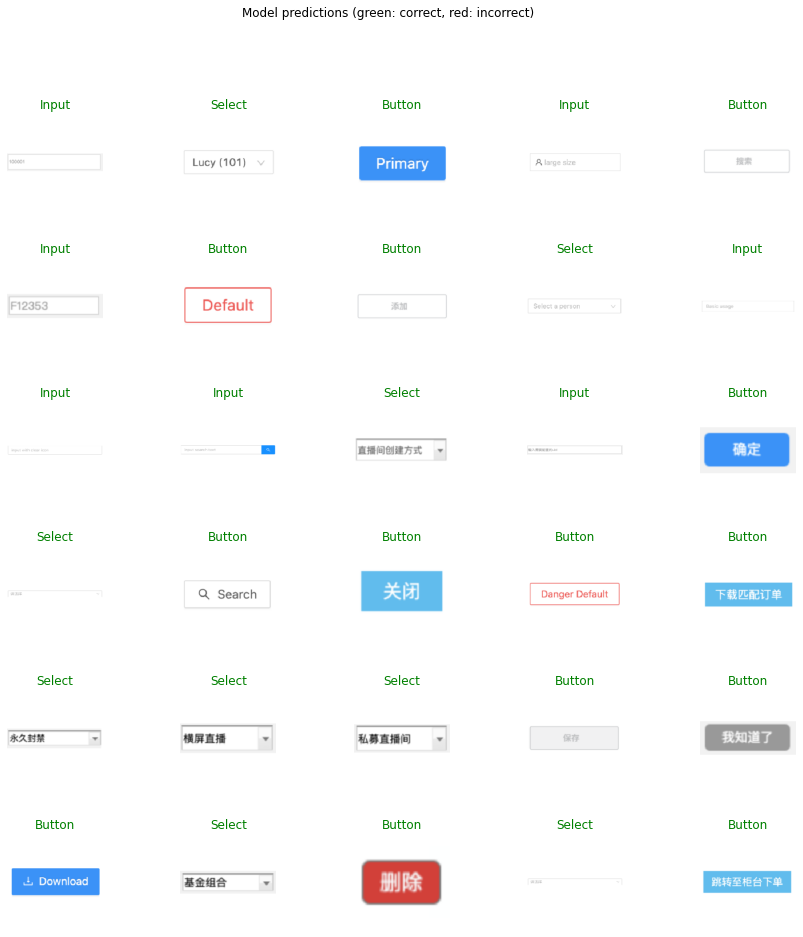

In [86]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [90]:
# 导出模型

import time
t = time.time()

export_path = "/content/model/{}".format(int(t))
model.save(export_path, save_format='tf')

!cp -r /content/model /content/drive/My\ Drive/Fast.io/ygd.imfast.io/model 
export_path

INFO:tensorflow:Assets written to: /content/model/1589361295/assets


INFO:tensorflow:Assets written to: /content/model/1589361295/assets


'/content/model/1589361295'

Now confirm that we can reload it, and it still gives the same results:

In [0]:
reloaded = tf.keras.models.load_model(export_path)

In [0]:
reloaded_result_batch = reloaded.predict(image_batch)
reloaded_result_batch